GRADIENT BOOSTING

"Boosting is a supervised learning method that consists in building a reliable prediction by aggregating the
responses of basic learners, i.e. estimators that are just better than chance".

GradientBoosting involves building a predictor incrementally.
Starting with a basic weak learner, each error (defined by various loss functions) is corrected by the addition of a new weak learner of the same nature, but associated with a specific coefficient and parameters.
The number of iterations of the algorithm, the weak learner and the loss function are parameters to be chosen.

It's called gradientBoosting because the choice of predictor weights and parameters is made via a gradient descent algorithm.

1. Libraries and Data Importation

In [15]:
# dependances
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import math
from time import perf_counter
%matplotlib inline
import seaborn
seaborn.set()
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, label_binarize
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_curve,
    auc,
    precision_recall_curve
)
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

(Functions from the notebook Boosting.ipynb)

A. Loss criteria

(1) moindre carre 
∀x,y∈R,
L(x,y)=1/2 * ∥x−y∥ **2.

MSE = mean squarred error

In [16]:
def mse(y,F):
    """
        Parameters:
        - y : array of length n = size_of_dataset
        - F : array of evaluations of the current Fhat estimator in the data X associated to y
    """
    return 0.5*(y-F)**2

def grad_mse(y,F):
    return((F-y))

plt.plot(np.linspace(-3,3,100),mse(np.linspace(-3,3,100),np.zeros(100)))
plt.title('Representation de la MSE');

(2) Least-absolute deviation

∀x,y∈R,L(x,y)=|x−y|.

LDA = Least-absolute deviation

In [17]:
def lad(y,F):
    """
        Parameters:
        - y : array of length n = size_of_dataset
        - F : array of evaluations of the current Fhat estimator in the data X associated to y
    """
    return(np.abs(y-F)) #return an array

def grad_lad(y,F):
    grad = (F-y) #sign inverted because we compute the gradient in the F variable
    grad[grad > 0] = 1 
    grad[grad < 0] = - 1
    return(grad)

plt.plot(np.linspace(-3,3,100), lad(np.linspace(-3,3,100), np.zeros(100)))
plt.title('Représentation de la LAD');

(3) Huber-M

∀x,y∈R,
L(x,y)= {1/2(y−y)**2 si |x−y|≤δ
        ,δ(|x−y|−δ/2) si |x−y|>δ,
for δ>0 called the tuning parameter.

In [18]:
def huber(y,F,delta):
    h = y-F
    h[np.abs(h)<=delta] = 0.5*h[np.abs(h)<=delta]**2
    h[np.abs(h)>delta] = delta*(np.abs(h[np.abs(h)>delta])-(delta/2))
    return h

def grad_huber(y,F,delta):
    h = y-F
    h[np.abs(h)<=delta] = -h[np.abs(h)<=delta]
    g = grad_ade(y[np.abs(h)>delta],F[np.abs(h)>delta])
    h[np.abs(h)>delta] = delta*g
    return h

plt.plot(np.linspace(-3,3,100), huber(np.linspace(-3,3,100), np.zeros(100),1.5)) #[if_true] if [expression] else [if_false]
plt.title('Représentation de la Huber');

(4) K-class multinomial negative log-likelihood

In [19]:
#Binomial negative log likelihood (2 class) 
def Bl(y,F):
    return np.log(1 + np.exp(-2*y*F))

def grad_Bl(y,F):
    return((-2*y*np.exp(-2*y*F)) / (1 + np.exp(-2*y*F)))

plt.plot(np.linspace(-1,1,100), Bl(np.linspace(-1,1,100), np.ones(100)))
plt.title('Représentation de la Logit');

In [20]:
from sklearn.tree import DecisionTreeRegressor
class GradientBoostingTree(object):
    def __init__(self, loss, learning_rate, n_estimators=10, criterion='friedman_mse', max_depth=3, max_samples=1.0, alpha=0.9):
        """
        Parameters:
        - loss: 'LS', 'LAD', 'Huber', 'LK' (LK : negativ log-likelihood for two classes)
        - grad: 'directly follows from the choice of the loss'
        - learning_rate: real number between 0 and 1 (small)
        - n_estimators: number of estimators
        - criterion: 'squared_error', 'friedman_mse', 'absolute_error'
        - max_depth: maximal depth of the regressor tree
        - max_samples: ratio of samples to use for learning base regressors.
            - If max_samples=1.0: use bootstrap.
            - If max_samples<1.0: use random sampling and extract max_samples x n points
            (where n is the total number of points).
        """
        # Parameters of GradientTreeBoosting
        self.loss = loss
        self.learning_rate = learning_rate
        self.n_estimators = n_estimators
        self.criterion = criterion
        self.max_depth = max_depth
        self.max_samples = max_samples
        self.alpha = alpha
        
    def starter(self, X, y):
        # Make X a 2d-array
        data = np.asarray(X)
        if data.ndim == 1:
            data = data[:, np.newaxis]
            
        self.n_data = data.shape[0]  # Sample size
        self.n_sample = int(self.max_samples * self.n_data)  # Number of points for random sampling
        self.y = y
        self.data = data
        
        self.estimators_ = []
        self.regions_train_ = []
        self.regions_ = []
        self.F = []
        
        # Initialisation of F_0
    
        if self.loss == 'LS' :
            self.init = np.mean(self.y)
            #from scipy.optimize import minimize_scalar
            #self.init = minimize_scalar(lambda x : np.sum(self.loss(y,x))).x 
        
        if self.loss == 'LAD' or self.loss == 'Huber' :
            self.init = np.median(self.y)
        
        if self.loss == 'LK' :
            self.init = 0.5*np.log((1+np.mean(self.y))/(1 - np.mean(self.y)))
            
        self.F.append(self.init*np.ones(self.n_data))
        
        return self
    
    def predict(self,X):
        # Make X a 2d-array
        X = np.asarray(X)
        if X.ndim == 1:
            X = X[:, np.newaxis]
            
        N_pred = X.shape[0] # Number of predictions
        pred = self.init*np.ones(N_pred) # Array of preds initialized at the same value (depends on the loss)

        # Build estimators
        for t in range(self.n_estimators):
            # 1 : Sample the dataset
            if self.max_samples==1:
                idx = np.arange(self.n_data)
                #idx = np.random.randint(0, self.n, self.n)  # Bootstrap
            else:
                idx = np.random.permutation(self.n_data)[:self.n_sample]  # Random sampling
            y_sample = self.y[idx]
            #y_sample = self.y.to_numpy()[idx]
            data_sample = self.data[idx]
            F = self.F[-1] 
            F_sample = F[idx]
                         
            # 2 Compute the pseudo residuals y_tilde
            
            if self.loss == 'LS' :
                y_tilde = y_sample - F_sample 
                self.estimators_.append(DecisionTreeRegressor(criterion = self.criterion, max_depth=self.max_depth))
                self.estimators_[-1].fit(data_sample, y_tilde)
                F_sample = F_sample + self.learning_rate*self.estimators_[-1].predict(data_sample) # TRAIN (F(data) only)
                pred = pred + self.learning_rate*self.estimators_[-1].predict(X) # PREDICT
            
            elif self.loss == 'LAD' :
                # y_tilde is the sign of residuals y - F
                y_tilde = y_sample - F_sample
                y_tilde[y_tilde>0] = 1
                y_tilde[y_tilde<0] = -1
                
                # We compute gamma for each region
                # Regions
                self.estimators_.append(DecisionTreeRegressor(criterion = self.criterion, max_depth=self.max_depth))
                self.estimators_[-1].fit(data_sample, y_tilde)
                self.regions_train_.append(self.estimators_[-1].apply(data_sample))
                self.regions_.append(self.estimators_[-1].apply(X))
                R_train = self.regions_train_[-1] # List of x_i's region
                IDR = np.unique(R_train) # Region name
                R = self.regions_[-1]
                # Gamma
                gamma = []
                for l in IDR:
                    idl = np.argwhere(R_train==l)
                    y_l = y_sample[idl]
                    F_l = F_sample[idl]
                    gamma.append(np.median(y_l - F_l))
                    F_sample[idl] = F_sample[idl] + self.learning_rate*gamma[-1] # TRAIN
                    
                for k in range(N_pred):
                    l = R[k] #region of x_new
                    i = np.argwhere(IDR==l)[0][0]
                    pred[k] = pred[k] + self.learning_rate*gamma[i] # PREDICT
                
            elif self.loss == 'Huber' :
                # Compute delta_m
                r = y_sample - F_sample # Current residuals
                delta = np.quantile(np.abs(r), self.alpha)
                y_tilde = r
                y_tilde[r>delta] = delta
                y_tilde[r<-delta] = -delta
                
                # Regions
                self.estimators_.append(DecisionTreeRegressor(criterion = self.criterion, max_depth = self.max_depth))
                self.estimators_[-1].fit(data_sample, y_tilde)
                self.regions_train_.append(self.estimators_[-1].apply(data_sample))
                self.regions_.append(self.estimators_[-1].apply(X))
                R_train = self.regions_train_[-1]
                IDR = np.unique(R_train)
                R = self.regions_[-1]
                # Gamma
                gamma = []
                for l in IDR:
                    idl = np.argwhere(R_train==l)
                    r_l = r[idl]
                    r_tilde = np.median(r_l)
                    r_ = r_l - r_tilde
                    
                    r_min = np.abs(r_)
                    r_min[r_min>delta] = delta
                    r_min[r_<0] = -r_min[r_<0]
                    
                    gamma.append(r_tilde + np.sum(r_min)/len(idl))
                    F_sample[idl] = F_sample[idl] + self.learning_rate*gamma[-1] # We update F and pred separatly
                    
                for k in range(N_pred):
                    l = R[k] #region of x_new
                    i = np.argwhere(IDR==l)[0][0]
                    pred[k] = pred[k] + self.learning_rate*gamma[i] # Update of each pred   
                    
            elif self.loss == 'LK' :
                marge = 2*y_sample*F_sample
                if np.sum(1*(marge > 709)) > 0:
                    marge[marge>709] = 709
                    
                y_tilde = (2*y_sample) / (1 + np.exp(marge))
                
                # Regions
                self.estimators_.append(DecisionTreeRegressor(criterion = self.criterion, max_depth = self.max_depth))
                self.estimators_[-1].fit(data_sample, y_tilde)
                self.regions_train_.append(self.estimators_[-1].apply(data_sample))
                self.regions_.append(self.estimators_[-1].apply(X))
                R_train = self.regions_train_[-1]
                IDR = np.unique(R_train)
                R = self.regions_[-1]
                # Gamma
                gamma = []
                for l in IDR:
                    idl = np.argwhere(R_train==l)
                    gamma.append(np.sum(y_tilde[idl] / np.sum(np.abs(y_tilde[idl])*(2-np.abs(y_tilde[idl])))))
                    F_sample[idl] = F_sample[idl] + self.learning_rate*gamma[-1] # We update F and pred separatly
                
                for k in range(N_pred):
                    l = R[k] #region of x_new
                    i = np.argwhere(IDR==l)[0][0]
                    pred[k] = pred[k] + self.learning_rate*gamma[i] # Update of each pred  
                            
            F[idx] = F_sample    
            self.F.append(F)           
        
        if self.loss == 'LK' :
            pred = 2*(pred > 0) - 1
            
        return pred 
    
    def error(self, X, y):
        # Make X a 2d-array
        X = np.asarray(X)
        if X.ndim == 1:
            X = X[:, np.newaxis]
        if self.loss == 'LK':
            err = np.mean(1*(self.predict(X)*y < 0))
        else :
            err = np.mean((y - self.predict(X))**2)
        return err
    

2. Gradient Boosting

“At each iteration, the learner trains on ˜n data drawn randomly and without discount from the training set”


"The stochastic version of Gradient Boosting is engaged when the user sets the proportion f of the Dn data to be used during random subsampling. Here are the error curves that can be expected as a function of the training step ν and the proportion f chosen"

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

# Chargement des données
data = pd.read_csv('data/Student_performance_data_new_GradeClass.csv')
data["obtention"] = np.where(data["GradeClass"] > 3, "echec", "reussite")
# Sélection des variables numériques
numeric_columns_new = data.select_dtypes(include=['number']).drop(['StudentID', 'GPA', 'GradeClass'], axis=1).columns

X = data[numeric_columns_new].to_numpy()
y = data["obtention"].to_numpy()

# Split train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=42
)

# Normalisation des features
scaler_X = StandardScaler()
X_train = scaler_X.fit_transform(X_train)
X_test = scaler_X.transform(X_test)

# Normalisation de y avec un scaler séparé
scaler_y = StandardScaler()
#y_train = scaler_y.fit_transform(y_train.reshape(-1, 1))[:, 0]
#y_test = scaler_y.transform(y_test.reshape(-1, 1))[:, 0]

# Paramètres
seed = 42
np.random.seed(seed)
Max_samples = [0.5, 0.7, 0.9]
nu = 0.01  # un peu plus élevé qu'avant
N_est = np.arange(1, 1501, step=100)
N_grid = np.arange(1, 1501, step=100)

best_error = float('inf')
best_model = None
best_params = {}

plt.figure(figsize=(6, 5))

for m in Max_samples:
    err = []
    for n_est in N_est:
        reg = GradientBoostingTree(
            loss='LS',
            learning_rate=nu,
            n_estimators=n_est,
            criterion='friedman_mse',
            max_depth=5,
            max_samples=m
        )
        reg.starter(X_train, y_train)
        current_error = reg.error(X_test, y_test)  # erreur standardisée
        err.append(current_error)

        # Sélection du meilleur modèle
        if current_error < best_error:
            best_error = current_error
            best_model = reg
            best_params = {'max_samples': m, 'n_estimators': n_est}

    plt.plot(N_est, err, label=f'prop = {m:.1f}')

plt.xlabel('Nombre de weak learners')
plt.xticks(N_grid, [str(N) for N in N_grid])
plt.ylabel('Erreur standardisée')
plt.title(fr'$\nu = {nu:.4f}$')
plt.legend()
plt.suptitle(f'Erreur LS TreeBoost stochastique sur student_perf')
plt.tight_layout()
plt.show()

# Évaluation réelle du meilleur modèle
y_pred = best_model.predict(X_test)
#y_pred_real = scaler_y.inverse_transform(y_pred.reshape(-1, 1))[:, 0]
y_pred_real = y_pred
#y_test_real = scaler_y.inverse_transform(y_test.reshape(-1, 1))[:, 0]
y_test_real = y_test

rmse = np.sqrt(mean_squared_error(y_test_real, y_pred_real))
r2 = r2_score(y_test_real, y_pred_real)

print("\nMeilleurs paramètres trouvés :", best_params)
print(f"RMSE réel : {rmse:.4f}")
print(f"R² réel   : {r2:.4f}")


TypeError: ufunc 'divide' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [ ]:
# Évaluation
print(f"Meilleur modèle : max_samples = {best_params['max_samples']}, "
      f"n_estimators = {best_params['n_estimators']}, erreur = {best_error:.4f}")



mse = mean_squared_error(y_test_real, y_pred_real)
mae = mean_absolute_error(y_test_real, y_pred_real)
r2 = r2_score(y_test_real, y_pred_real)

print(f"Mean Squared Error: {mse:.2f}")
print(f"Mean Absolute Error: {mae:.2f}")
print(f"R² Score: {r2:.2f}")

def classification_classe(gpa):
    if gpa >= 3.5:
        return 0  # A
    elif gpa >= 3.0:
        return 1  # B
    elif gpa >= 2.5:
        return 2  # C
    elif gpa >= 2.0:
        return 3  # D
    else:
        return 4  # F

# Encodage des classes
y_test_class = pd.Series(y_test_real).apply(classification_classe)
y_pred_class = pd.Series(y_pred_real).apply(classification_classe)

# Rapport de classification
print("Classification report:")
print(classification_report(y_test_class, y_pred_class, target_names=['A', 'B', 'C', 'D', 'F'], zero_division=0 ))

KeyError: 'max_samples'

In [ ]:
# pre-traitement des donnees

# ICI ON NE GARDE QUE LES DONNEES NUMERIQUES, PAS D'ENCODAGE
data = pd.read_csv('data/Student_performance_data_new_GradeClass.csv')

# pre-traitement

X = data.drop(["GPA", "GradeClass"], axis=1)
y = data["GPA"]
numeric_columns_new = data.select_dtypes(include=['number']).drop(['StudentID', "GPA", "GradeClass"], axis=1).columns

X = X[numeric_columns_new].to_numpy()
y = y.to_numpy()

print(np.any(np.isnan(y)))

X_train, X_test, y_train, y_test = train_test_split(
   X, y, test_size=0.1, random_state=42
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

y_train = scaler.fit_transform(y_train.reshape(-1, 1))[:, 0]
y_test = scaler.transform(y_test.reshape(-1, 1))[:, 0]



#
seed = 42
np.random.seed(seed)
Max_samples = [0.5,0.7,0.9]
nu = 0.0015
N_est = np.arange(1, 1501, step=100)
N_grid = np.arange(1, 1501, step=100)


plt.figure(figsize=(5,4))

for m in Max_samples:
    err = []
    for n_est in N_est:
        reg = GradientBoostingTree(loss='LS',learning_rate=nu, n_estimators=n_est, criterion='friedman_mse', max_depth=5, max_samples=m)
        reg.starter(X_train,y_train)
        current_error = reg.error(X_test, y_test)
        err.append(current_error)
        #i_min = np.argmin(np.array(err))
         # Mise à jour du meilleur modèle
        if current_error < best_error:
            best_error = current_error
            best_model = reg
            best_params = {'max_samples': m, 'n_estimators': n_est}
    
    
    plt.plot(N_est, err, label=f'prop = {m:.1f}')
    #if it > 5 :
    plt.xlabel('Nombre de weak learners')
    plt.xticks(N_grid, [str(N) for N in N_grid])
    plt.ylabel('Erreur')
    #plt.ylim(0,0.5)
    plt.title(fr'$\nu = {nu:.4f}$')
    plt.legend()
plt.suptitle(f'Erreur LS TreeBoost stochastique sur student_perf')
plt.tight_layout

# v est le learning rate, c'est un coefficient multiplie aux nouveaux predicteurs a chaque iteration
# plus il est eleve, plus le modele apprends vite, mais il a un risque d'overfitting
# plus petit, meilleur prediction, mais plus lent, necessite plus d'iterations
# en absisse, nombre de predicteurs
# prop est la proportion de l'ensemble utilise pour apprendre, choisir le nouvel apprenant

# plus de 3 min d'exec pour 1500 apprenants

False


In [ ]:
# Évaluation
print(f" Meilleur modèle : max_samples = {best_params['max_samples']}, "
      f"n_estimators = {best_params['n_estimators']}, erreur = {best_error:.4f}")

y_pred = best_model.predict(X_test)

# Déstandardisation des prédictions si besoin
y_pred = scaler.inverse_transform(y_pred.reshape(-1, 1))[:, 0]
y_test_real = scaler.inverse_transform(y_test.reshape(-1, 1))[:, 0]

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse:.2f}")
print(f"Mean Absolute Error: {mae:.2f}")
print(f"R² Score: {r2:.2f}")

def classification_classe(gpa):
    if gpa >= 3.5:
        return 0  # A
    elif gpa >= 3.0:
        return 1  # B
    elif gpa >= 2.5:
        return 2  # C
    elif gpa >= 2.0:
        return 3  # D
    else:
        return 4  # F

# Encodage des classes
y_test_class = pd.Series(y_test_real).apply(classification_classe)
y_pred_class = pd.Series(y_pred).apply(classification_classe)

# Rapport de classification
print("Classification report:")
print(classification_report(y_test_class, y_pred_class, target_names=['A', 'B', 'C', 'D', 'F'], zero_division=0 ))

Mean Squared Error: 4.80
Mean Absolute Error: 1.95
R² Score: -3.58
Classification report:
              precision    recall  f1-score   support

           A       0.00      0.00      0.00         9
           B       0.00      0.00      0.00        25
           C       0.00      0.00      0.00        38
           D       0.00      0.00      0.00        38
           F       0.54      1.00      0.70       130

    accuracy                           0.54       240
   macro avg       0.11      0.20      0.14       240
weighted avg       0.29      0.54      0.38       240



3. Gradient boosting avec sklearn

(1) With 2 classes : Pass and Fail

In [ ]:
data = pd.read_csv('data/Student_performance_data_new_GradeClass.csv')

# pre-traitement
data["obtention"] = np.where(data["GradeClass"] > 3, "echec", "reussite")
X = data.drop(["GPA", "GradeClass", "obtention",'StudentID'], axis=1)
y = data["obtention"]

X_train, X_test, y_train, y_test = train_test_split(
   X, y, test_size=0.2, random_state=42
)

categorical_features = X.select_dtypes(
   include=["object"]
).columns.tolist()

numerical_features = X.select_dtypes(
   include=["float64", "int64"]
).columns.tolist()

preprocessor = ColumnTransformer(
   transformers=[
       ("cat", OneHotEncoder(), categorical_features),
       ("num", StandardScaler(), numerical_features),
   ]
)

pipeline = Pipeline(
   [
       ("preprocessor", preprocessor),
       ("classifier", GradientBoostingClassifier(random_state=42)), # sur variable qualitative nominale
   ]
)

# Perform 5-fold cross-validation
cv_scores = cross_val_score(pipeline, X_train, y_train, cv=5)

# Fit the model on the training data
pipeline.fit(X_train, y_train)

# Predict on the test set
y_pred = pipeline.predict(X_test)

# Generate classification report
report = classification_report(y_test, y_pred)

In [ ]:
print(f"Mean Cross-Validation Accuracy: {cv_scores.mean():.4f}")
print("\nClassification Report:")
print(report)

TP : true positive
TN : true negative
FN : false negative
FP : false positive

precision : TP/(TP+TN), proportion de predictions correctes
recall : TP/(TP+FP), proportion de la classe detectee
f1-score : 2* precision*recall/(precision + recall) 
support : nombre d'individus de la classe

accuracy: (TP+TN)/(TP + TN + FN + FP),proportion totale de predictions correctes
macro avg : moyenne non ponderee des precisions
weighted avg : moyenne ponderee par le support des precisions

Le modele est solide : il est precis a plus de 90% pour les deux classes (il predit la bonne classe a plus de 90%) et determine a plus de 90% tous les membres d'une classe.


seuil de decision par defaut 0.5

recherche du meilleur seuil : 

seuils = np.linspace(0, 1, 100)
best_seuil = 0.5
best_acc = 0

for seuil in seuils:
    y_pred = (y_score >= seuil).astype(int)
    acc = accuracy_score(y_test_bin, y_pred)
    if acc > best_acc:
        best_acc = acc
        best_seuil = seuil

print(f"Meilleur seuil: {best_seuil:.2f} avec une accuracy de {best_acc:.3f}")


In [ ]:
# ============================
#       VISUALISATIONS
# ============================

# 1. MATRICE DE CONFUSION
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Créer la matrice de confusion : compare les vraies classes à celles prédites
# L'ordre des classes est précisé pour la cohérence ("accepte" en premier)
cm = confusion_matrix(y_test, y_pred, labels=["reussite", "echec"])

# Affichage graphique avec étiquettes
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["reussite", "echec"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Matrice de confusion")
plt.show()

# ----------------------------------------

# 2. COURBE ROC (Receiver Operating Characteristic)
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Binarisation de la variable cible : accepte = 1, rejete = 0
# Nécessaire pour les courbes ROC/PR qui exigent des labels binaires
y_test_bin = label_binarize(y_test, classes=["echec", "reussite"])

# Obtenir la probabilité prédite pour la classe "accepte"
y_score = pipeline.predict_proba(X_test)[:, 1]

# Calcul des taux de faux positifs (FPR) et vrais positifs (TPR)
fpr, tpr, thresholds = roc_curve(y_test_bin, y_score)

# Calcul de l'aire sous la courbe (AUC)
roc_auc = auc(fpr, tpr)

# Tracer la courbe ROC
plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], 'k--')  # ligne diagonale = modèle aléatoire
plt.xlabel("Taux de faux positifs (FPR)")
plt.ylabel("Taux de vrais positifs (TPR)")
plt.title("Courbe ROC")
plt.legend(loc="lower right")
plt.grid()
plt.show()

# ----------------------------------------

# 3. COURBE PRÉCISION-RAPPEL
from sklearn.metrics import precision_recall_curve

# Calcul des valeurs de précision et rappel à différents seuils
precision, recall, _ = precision_recall_curve(y_test_bin, y_score)

# Tracé de la courbe
plt.plot(recall, precision, marker='.')
plt.xlabel("Rappel (Recall)")
plt.ylabel("Précision (Precision)")
plt.title("Courbe Précision-Rappel")
plt.grid()
plt.show()

# ----------------------------------------

# 4. PROJECTION PCA POUR VISUALISER LES ERREURS DE CLASSIFICATION
from sklearn.decomposition import PCA

# Appliquer uniquement le préprocesseur sur X_test (sans le modèle)
X_test_transformed = pipeline.named_steps["preprocessor"].transform(X_test)

# Certains encodeurs retournent des matrices clairsemées → conversion possible
X_test_array = X_test_transformed.toarray() if hasattr(X_test_transformed, "toarray") else X_test_transformed

# Réduction de dimension à 2 composantes principales (PCA)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_test_array)

# Identifier les prédictions correctes (True/False pour chaque observation)
correct = (y_test.values == y_pred)

# Tracé des points en 2D :
# - Verts pour les exemples bien classés
# - Rouges pour les erreurs de prédiction
plt.scatter(X_pca[correct, 0], X_pca[correct, 1], c='green', label='Bien classés', alpha=0.6)
plt.scatter(X_pca[~correct, 0], X_pca[~correct, 1], c='red', label='Mal classés', alpha=0.6)
plt.xlabel('Composante principale 1')
plt.ylabel('Composante principale 2')
plt.title('Projection PCA des données testées')
plt.legend()
plt.grid()
plt.show()


(2) prediction sur gradeClass (variable quantitative continue)

In [ ]:
data = pd.read_csv('data/Student_performance_data_new_GradeClass.csv')

# pre-traitement
X = data.drop(["GPA", "GradeClass",'StudentID'], axis=1)
y = data["GPA"]





X_train, X_test, y_train, y_test = train_test_split(
   X, y, test_size=0.2, random_state=42
)

categorical_features = X.select_dtypes(
   include=["object"]
).columns.tolist()

numerical_features = X.select_dtypes(
   include=["float64", "int64"]
).columns.tolist()

preprocessor = ColumnTransformer(
   transformers=[
       ("cat", OneHotEncoder(), categorical_features),
       ("num", StandardScaler(), numerical_features),
   ]
)

pipeline = Pipeline(
   [
       ("preprocessor", preprocessor),
       ("classifier", GradientBoostingRegressor(random_state=42)), # sur variable qualitative nominale
   ]
)

# Perform 5-fold cross-validation
cv_scores = cross_val_score(pipeline, X_train, y_train, cv=5)

# Fit the model on the training data
pipeline.fit(X_train, y_train)

# Predict on the test set
# il faut arondir les predictions (continues) pour obtenir les classes d'origine
y_pred = pipeline.predict(X_test)


In [ ]:
# Évaluation
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse:.2f}")
print(f"Mean Absolute Error: {mae:.2f}")
print(f"R² Score: {r2:.2f}")

def classification_classe(gpa):
    if gpa >= 3.5:
        return 0  # A
    elif gpa >= 3.0:
        return 1  # B
    elif gpa >= 2.5:
        return 2  # C
    elif gpa >= 2.0:
        return 3  # D
    else:
        return 4  # F

# Encodage des classes
y_test_class = y_test.apply(classification_classe)
y_pred_class = pd.Series(y_pred).apply(classification_classe)

# Classification report
print(classification_report(y_test_class, y_pred_class, target_names=["A", "B", "C", "D", "F"]))

# MAE entre classes ordinales

# moyenne des ecarts absolus entre les predictions et les vraies valeurs
mae_ordinale = mean_absolute_error(y_test_class, y_pred_class)
print(f"Erreur absolue moyenne entre classes ordinales : {mae_ordinale:.2f}")

Mean Squared Error: 0.04
Mean Absolute Error: 0.17
R² Score: 0.95
              precision    recall  f1-score   support

           A       1.00      0.38      0.55        16
           B       0.64      0.73      0.69        49
           C       0.67      0.69      0.68        80
           D       0.67      0.66      0.66        85
           F       0.94      0.95      0.94       249

    accuracy                           0.81       479
   macro avg       0.78      0.68      0.70       479
weighted avg       0.82      0.81      0.81       479

Erreur absolue moyenne entre classes ordinales : 0.19


test de meilleurs combinaisons de 2 a 5 variables 

In [ ]:
import pandas as pd
import itertools
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score

# Charger les données
data = pd.read_csv('data/Student_performance_data_new_GradeClass.csv')

# Cible
y = data["GPA"]

# Supprimer la cible et la variable GradeClass
X_full = data.drop(["GPA", "GradeClass",'StudentID'], axis=1)

# Séparer en train/test une fois pour tous
X_train_full, X_test_full, y_train, y_test = train_test_split(X_full, y, test_size=0.2, random_state=42)

# Colonnes catégorielles et numériques complètes
categorical_features_all = X_full.select_dtypes(include=["object"]).columns.tolist()
numerical_features_all = X_full.select_dtypes(include=["float64", "int64"]).columns.tolist()

# Stockage des scores
results = []

# Boucle sur les combinaisons de variables (de 2 à 5)
for r in range(2, 6):
    for subset in itertools.combinations(X_full.columns, r):
        subset = list(subset)
        X_train = X_train_full[subset]
        X_test = X_test_full[subset]

        # Déterminer les colonnes catégorielles et numériques pour ce sous-ensemble
        categorical_features = [col for col in subset if col in categorical_features_all]
        numerical_features = [col for col in subset if col in numerical_features_all]

        # Pipeline
        preprocessor = ColumnTransformer([
            ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
            ("num", StandardScaler(), numerical_features),
        ])

        pipeline = Pipeline([
            ("preprocessor", preprocessor),
            ("regressor", GradientBoostingRegressor(random_state=42)),
        ])

        # Validation croisée
        scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring="r2")
        mean_score = scores.mean()

        # Enregistrer le résultat
        results.append({
            "Variables": subset,
            "R2_score": mean_score
        })

# Convertir en DataFrame et trier
results_df = pd.DataFrame(results)
top_10 = results_df.sort_values(by="R2_score", ascending=False).head(10)

# Affichage
print("\nTop 10 des combinaisons de variables par score R² :\n")
print(top_10.to_string(index=False))


# 1212 secondes


Top 10 des combinaisons de variables par score R² :

                                                                     Variables  R2_score
       [StudyTimeWeekly, Absences, Tutoring, ParentalSupport, totalActivities]  0.942129
       [StudyTimeWeekly, Absences, Tutoring, ParentalSupport, Extracurricular]  0.934639
                [StudyTimeWeekly, Absences, Tutoring, ParentalSupport, Sports]  0.932351
   [StudyTimeWeekly, Absences, ParentalSupport, Volunteering, totalActivities]  0.928930
                 [StudyTimeWeekly, Absences, Tutoring, ParentalSupport, Music]  0.928093
[StudyTimeWeekly, Absences, ParentalSupport, Extracurricular, totalActivities]  0.925328
         [StudyTimeWeekly, Absences, ParentalSupport, Extracurricular, Sports]  0.925079
         [StudyTimeWeekly, Absences, ParentalSupport, Sports, totalActivities]  0.924852
                   [Age, StudyTimeWeekly, Absences, Tutoring, ParentalSupport]  0.924372
          [StudyTimeWeekly, Absences, Tutoring, Parental


Évaluation du modèle pour la combinaison de variables #2245 :
Variables utilisées : ['StudyTimeWeekly', 'Absences', 'Tutoring', 'ParentalSupport', 'totalActivities']
  - R² : 0.929 | MAE : 0.193 | MSE : 0.062

Rapport de classification A–F :
              precision    recall  f1-score   support

           A       0.75      0.33      0.46         9
           B       0.64      0.84      0.72        25
           C       0.78      0.76      0.77        38
           D       0.72      0.55      0.63        38
           F       0.91      0.96      0.94       130

    accuracy                           0.83       240
   macro avg       0.76      0.69      0.70       240
weighted avg       0.83      0.83      0.82       240

Erreur absolue moyenne entre classes ordinales : 0.17


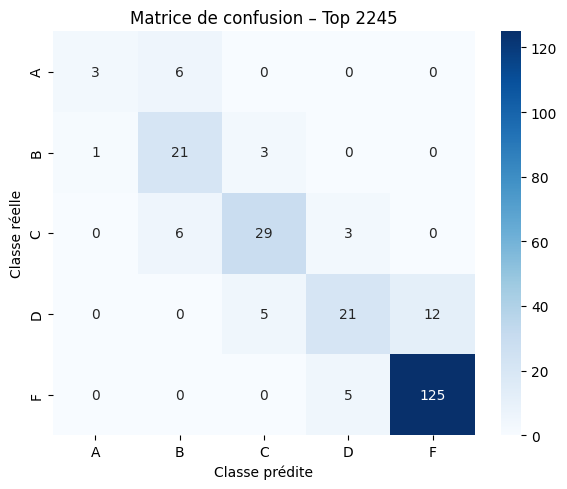


Évaluation du modèle pour la combinaison de variables #2241 :
Variables utilisées : ['StudyTimeWeekly', 'Absences', 'Tutoring', 'ParentalSupport', 'Extracurricular']
  - R² : 0.926 | MAE : 0.195 | MSE : 0.064

Rapport de classification A–F :
              precision    recall  f1-score   support

           A       0.60      0.33      0.43         9
           B       0.56      0.72      0.63        25
           C       0.71      0.66      0.68        38
           D       0.66      0.50      0.57        38
           F       0.90      0.96      0.93       130

    accuracy                           0.79       240
   macro avg       0.69      0.63      0.65       240
weighted avg       0.79      0.79      0.78       240

Erreur absolue moyenne entre classes ordinales : 0.21


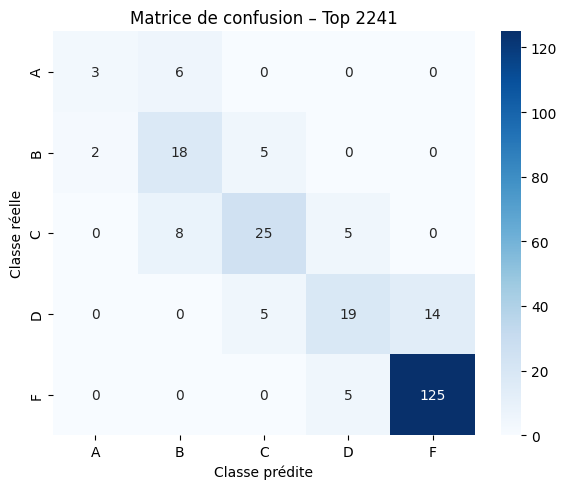


Évaluation du modèle pour la combinaison de variables #2242 :
Variables utilisées : ['StudyTimeWeekly', 'Absences', 'Tutoring', 'ParentalSupport', 'Sports']
  - R² : 0.927 | MAE : 0.193 | MSE : 0.064

Rapport de classification A–F :
              precision    recall  f1-score   support

           A       0.75      0.33      0.46         9
           B       0.62      0.80      0.70        25
           C       0.74      0.74      0.74        38
           D       0.67      0.53      0.59        38
           F       0.91      0.95      0.93       130

    accuracy                           0.81       240
   macro avg       0.74      0.67      0.68       240
weighted avg       0.81      0.81      0.81       240

Erreur absolue moyenne entre classes ordinales : 0.19


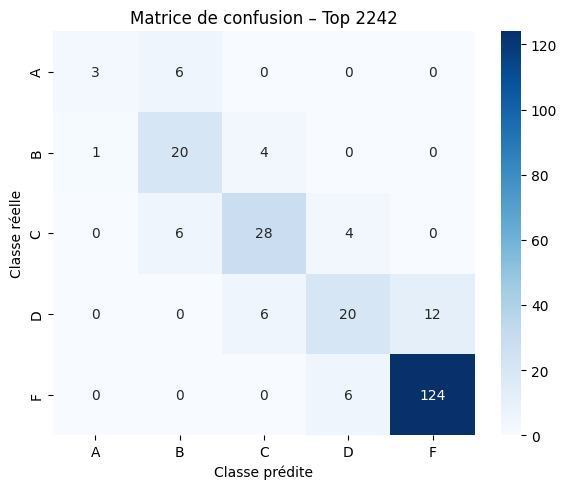


Évaluation du modèle pour la combinaison de variables #2265 :
Variables utilisées : ['StudyTimeWeekly', 'Absences', 'ParentalSupport', 'Volunteering', 'totalActivities']
  - R² : 0.918 | MAE : 0.213 | MSE : 0.072

Rapport de classification A–F :
              precision    recall  f1-score   support

           A       0.80      0.44      0.57         9
           B       0.52      0.64      0.57        25
           C       0.57      0.53      0.55        38
           D       0.53      0.42      0.47        38
           F       0.89      0.95      0.92       130

    accuracy                           0.75       240
   macro avg       0.66      0.60      0.62       240
weighted avg       0.74      0.75      0.74       240

Erreur absolue moyenne entre classes ordinales : 0.25


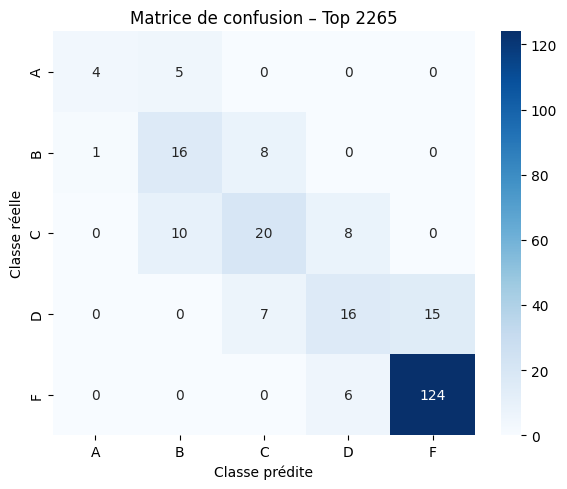


Évaluation du modèle pour la combinaison de variables #2243 :
Variables utilisées : ['StudyTimeWeekly', 'Absences', 'Tutoring', 'ParentalSupport', 'Music']
  - R² : 0.918 | MAE : 0.207 | MSE : 0.072

Rapport de classification A–F :
              precision    recall  f1-score   support

           A       0.50      0.33      0.40         9
           B       0.53      0.68      0.60        25
           C       0.70      0.68      0.69        38
           D       0.69      0.47      0.56        38
           F       0.90      0.96      0.93       130

    accuracy                           0.79       240
   macro avg       0.67      0.63      0.64       240
weighted avg       0.78      0.79      0.78       240

Erreur absolue moyenne entre classes ordinales : 0.21


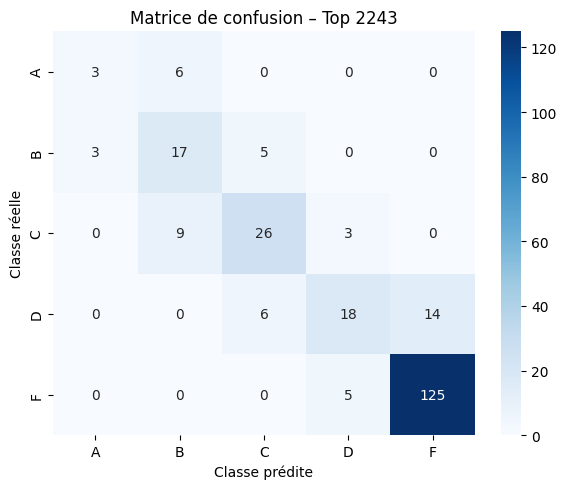


Évaluation du modèle pour la combinaison de variables #2259 :
Variables utilisées : ['StudyTimeWeekly', 'Absences', 'ParentalSupport', 'Extracurricular', 'totalActivities']
  - R² : 0.919 | MAE : 0.210 | MSE : 0.071

Rapport de classification A–F :
              precision    recall  f1-score   support

           A       0.75      0.33      0.46         9
           B       0.55      0.68      0.61        25
           C       0.63      0.58      0.60        38
           D       0.53      0.45      0.49        38
           F       0.89      0.95      0.92       130

    accuracy                           0.76       240
   macro avg       0.67      0.60      0.62       240
weighted avg       0.75      0.76      0.75       240

Erreur absolue moyenne entre classes ordinales : 0.24


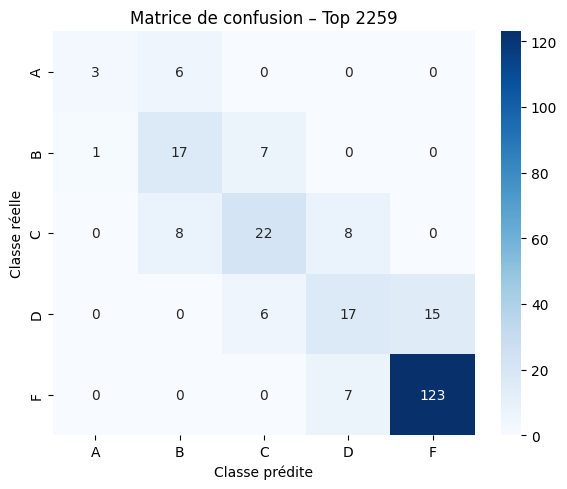


Évaluation du modèle pour la combinaison de variables #2256 :
Variables utilisées : ['StudyTimeWeekly', 'Absences', 'ParentalSupport', 'Extracurricular', 'Sports']
  - R² : 0.926 | MAE : 0.195 | MSE : 0.064

Rapport de classification A–F :
              precision    recall  f1-score   support

           A       0.60      0.33      0.43         9
           B       0.52      0.52      0.52        25
           C       0.61      0.61      0.61        38
           D       0.55      0.45      0.49        38
           F       0.89      0.96      0.92       130

    accuracy                           0.75       240
   macro avg       0.63      0.57      0.59       240
weighted avg       0.74      0.75      0.74       240

Erreur absolue moyenne entre classes ordinales : 0.25


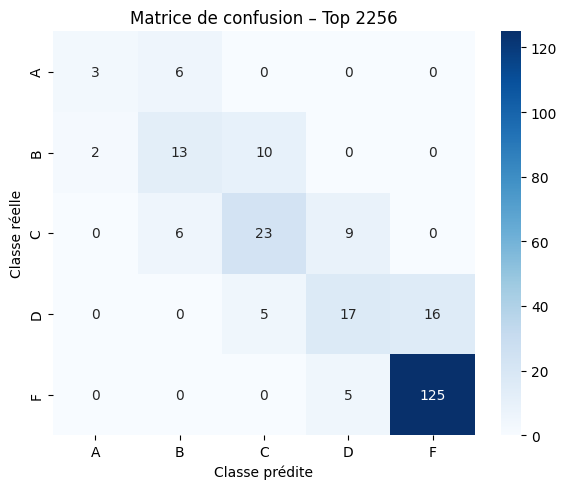


Évaluation du modèle pour la combinaison de variables #2262 :
Variables utilisées : ['StudyTimeWeekly', 'Absences', 'ParentalSupport', 'Sports', 'totalActivities']
  - R² : 0.918 | MAE : 0.213 | MSE : 0.072

Rapport de classification A–F :
              precision    recall  f1-score   support

           A       0.80      0.44      0.57         9
           B       0.52      0.60      0.56        25
           C       0.58      0.58      0.58        38
           D       0.57      0.45      0.50        38
           F       0.90      0.95      0.93       130

    accuracy                           0.76       240
   macro avg       0.67      0.60      0.63       240
weighted avg       0.75      0.76      0.75       240

Erreur absolue moyenne entre classes ordinales : 0.24


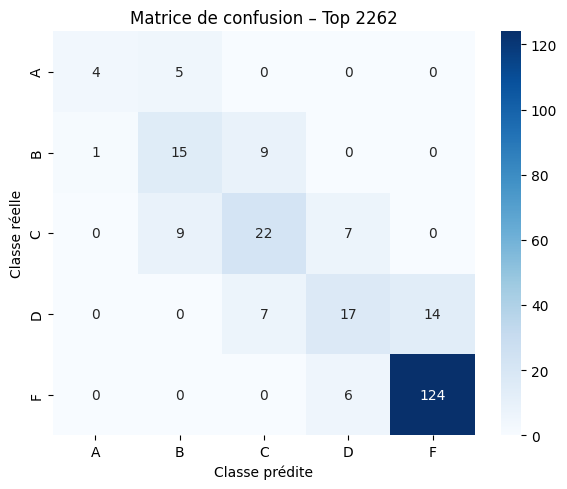


Évaluation du modèle pour la combinaison de variables #1449 :
Variables utilisées : ['Age', 'StudyTimeWeekly', 'Absences', 'Tutoring', 'ParentalSupport']
  - R² : 0.921 | MAE : 0.201 | MSE : 0.069

Rapport de classification A–F :
              precision    recall  f1-score   support

           A       0.75      0.33      0.46         9
           B       0.58      0.76      0.66        25
           C       0.70      0.68      0.69        38
           D       0.62      0.47      0.54        38
           F       0.90      0.95      0.92       130

    accuracy                           0.79       240
   macro avg       0.71      0.64      0.65       240
weighted avg       0.78      0.79      0.78       240

Erreur absolue moyenne entre classes ordinales : 0.21


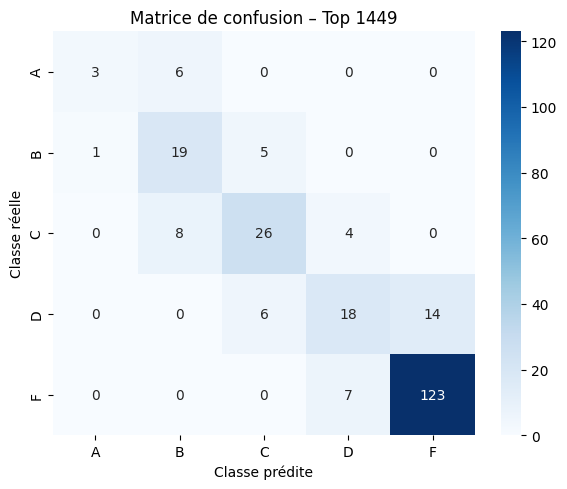


Évaluation du modèle pour la combinaison de variables #2244 :
Variables utilisées : ['StudyTimeWeekly', 'Absences', 'Tutoring', 'ParentalSupport', 'Volunteering']
  - R² : 0.917 | MAE : 0.210 | MSE : 0.073

Rapport de classification A–F :
              precision    recall  f1-score   support

           A       0.60      0.33      0.43         9
           B       0.53      0.72      0.61        25
           C       0.68      0.61      0.64        38
           D       0.59      0.45      0.51        38
           F       0.89      0.95      0.92       130

    accuracy                           0.77       240
   macro avg       0.66      0.61      0.62       240
weighted avg       0.76      0.77      0.76       240

Erreur absolue moyenne entre classes ordinales : 0.23


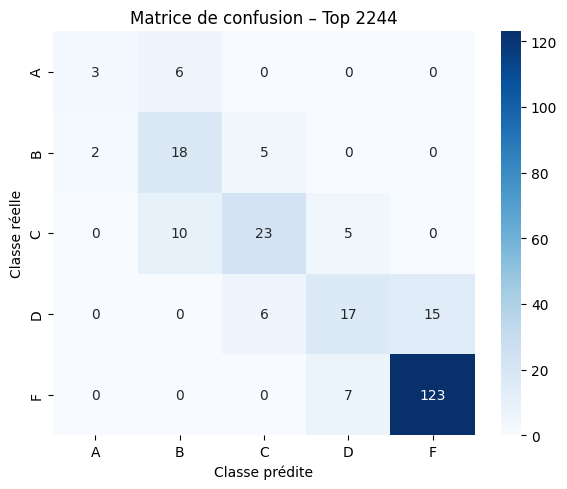

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import (
    mean_squared_error, mean_absolute_error, r2_score,
    classification_report, confusion_matrix
)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# -------- Fonction de classification A–F --------
def classification_classe(gpa):
    if gpa >= 3.5:
        return 0  # A
    elif gpa >= 3.0:
        return 1  # B
    elif gpa >= 2.5:
        return 2  # C
    elif gpa >= 2.0:
        return 3  # D
    else:
        return 4  # F

# -------- Affichage de la matrice de confusion --------
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    labels = ["A", "B", "C", "D", "F"]
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.xlabel("Classe prédite")
    plt.ylabel("Classe réelle")
    plt.title(title)
    plt.tight_layout()
    plt.show()

# -------- Traitement pour les 10 meilleures combinaisons --------
for i, row in top_10.iterrows():
    variable_subset = row["Variables"]  # supposé être une liste de colonnes
    print(f"\n\033[1mÉvaluation du modèle pour la combinaison de variables #{i + 1} :\033[0m")
    print(f"Variables utilisées : {variable_subset}")

    # Extraction des données
    X = data[variable_subset]
    y = data["GPA"]

    # Split + standardisation
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
    scaler_X = StandardScaler()
    X_train_scaled = scaler_X.fit_transform(X_train)
    X_test_scaled = scaler_X.transform(X_test)

    # Régression Random Forest
    modele_rf = RandomForestRegressor(n_estimators=100, random_state=42)
    modele_rf.fit(X_train_scaled, y_train)
    y_pred = modele_rf.predict(X_test_scaled)

    # --- Évaluation régression ---
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f"  - R² : {r2:.3f} | MAE : {mae:.3f} | MSE : {mse:.3f}")

    # --- Classification ordinale ---
    y_test_class = pd.Series(y_test).apply(classification_classe)
    y_pred_class = pd.Series(y_pred).apply(classification_classe)

    print("\nRapport de classification A–F :")
    print(classification_report(y_test_class, y_pred_class, target_names=["A", "B", "C", "D", "F"]))

    mae_ordinale = mean_absolute_error(y_test_class, y_pred_class)
    print(f"Erreur absolue moyenne entre classes ordinales : {mae_ordinale:.2f}")

    # --- Affichage de la matrice de confusion ---
    plot_confusion_matrix(y_test_class, y_pred_class, title=f"Matrice de confusion – Top {i+1}")